In [1]:
import os
from pprint import pprint

import numpy as np
import IPython.display
from tqdm import tqdm
import PIL
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense, GRU, Activation,
                                     Lambda)
from tensorflow.keras.optimizers import RMSprop

import numpy as np

In [2]:
from writenn.datagen.gen2 import DataGenerator2

data_path = "DATA_test/"

Gen = DataGenerator2(data_path, test_mode=True)
Gen.create()


  0%|          | 0/10 [00:00<?, ?it/s]

data size =  750


100%|██████████| 10/10 [01:25<00:00,  8.56s/it]


In [3]:
HERE = "."
path_img_folder = os.path.join(HERE, data_path, "img") + "/."
path_dot_folder = os.path.join(HERE, data_path, "dot") + "/."

IMG_HEIGHT = 299
IMG_WIDTH = 299

In [4]:
def simplify_dot(path_dot_file):
    with open(path_dot_file, "r") as f:
        s = f.read()
        s = s.replace("->", ">")
        s = s.replace(" ", "")
        s = s.replace("\t", "")
        s = s.replace("\n", "")
        s = s.split('""')[-1]
    return s


def test_simplify_dot():
    fname_img = "r-1_h-1_p0_nsh-circle_l-circo_ah-normal.png"
    fname_dot = "_".join(fname_img.split("_")[:3]) + ".dot"

    path_fname_dot = os.path.join(path_dot_folder, fname_dot)

    s = simplify_dot(path_fname_dot)
    print(s)

test_simplify_dot()

{0>1;}


In [5]:
def convert_dot(path_dot_folder):
    for fname in tqdm(os.listdir(path_dot_folder)):
        if fname[-4:] == ".dot" and fname[:2] != "s_":
            with open(os.path.join(path_dot_folder, "s_" + fname), "w") as f:
                f.write(simplify_dot(os.path.join(path_dot_folder, fname)))


def test_convert_dot():
    convert_dot(path_dot_folder)

test_convert_dot()

100%|██████████| 62/62 [00:00<00:00, 5709.54it/s]


In [6]:
def get_max_dim(path_img_folder):
    max_height, max_width = 0, 0
    for fname_img in tqdm(os.listdir(path_img_folder)):
        if fname_img[-4:] == ".png":
            path_img_file = os.path.join(path_img_folder, fname_img)
            img = tf.io.read_file(path_img_file)
            img = tf.image.decode_png(img, channels=3)
            shp = np.shape(img.numpy())
            max_height = max(shp[0], max_height)
            max_width = max(shp[1], max_width)
    return max_height, max_width
max_height, max_width = get_max_dim(path_img_folder)
print("MAX Height: ", max_height)
print("MAX Width : ", max_width)

100%|██████████| 2325/2325 [00:01<00:00, 1257.43it/s]

MAX Height:  766
MAX Width :  1360


In [7]:
def get_max_len(path_dot_folder):
    max_len = 0
    for fname_dot in tqdm(os.listdir(path_dot_folder)):
        if fname_dot[:2] == "s_":
            path_dot_file = os.path.join(path_dot_folder, fname_dot)
            with open(path_dot_file, "r") as f:
                s = f.read()
            max_len = max(len(s), max_len)
    return max_len
absolute_max_string_len = get_max_len(path_dot_folder)
print("Absolute MAX string length: ", absolute_max_string_len)

100%|██████████| 62/62 [00:00<00:00, 22988.58it/s]

Absolute MAX string length:  44


In [8]:
def convert_img(path_img_file):
    img = tf.io.read_file(path_img_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.transpose(img)
    img = tf.constant(255, dtype=tf.uint8) - img
    img = tf.image.resize_with_pad(img, target_height=max_height, target_width=max_width)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img

def test_convert_img():
    path_img_folder = os.path.join(HERE, "img") + "/."
    convert_img(path_img_folder)

In [9]:
def generate_dataset(path_img_folder, path_dot_folder):
    convert_dot(path_dot_folder)

    img_data, label_data = [], []
    for fname_img in tqdm(os.listdir(path_img_folder)):
        if fname_img[-4:] == ".png":
            conv_img = convert_img(os.path.join(path_img_folder, fname_img))
            fname_dot = "s_" + "_".join(fname_img.split("_")[:3]) + ".dot"
            with open(os.path.join(path_dot_folder, fname_dot), "r") as f:
                s_dot = f.read()
                img_data.append(conv_img)
                label_data.append(s_dot)
    return img_data, label_data


def get_data():
    data = generate_dataset(path_img_folder, path_dot_folder)
    return data

if __name__ == "__main__":
    data = get_data()
    print(np.shape(data[0][0]))

100%|██████████| 2325/2325 [00:28<00:00, 82.57it/s]

(299, 299, 3)


In [10]:
def showimg(imgarr):
    img = np.uint8(imgarr)
    IPython.display.display(PIL.Image.fromarray(img))

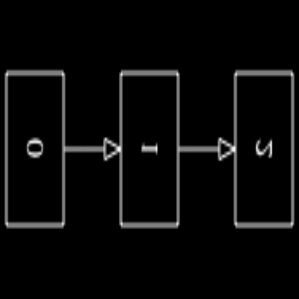

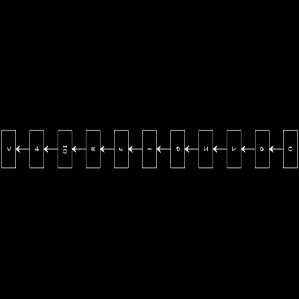

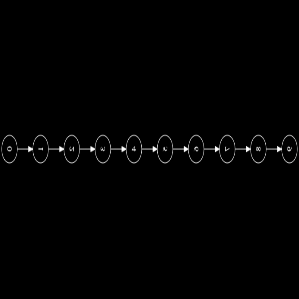

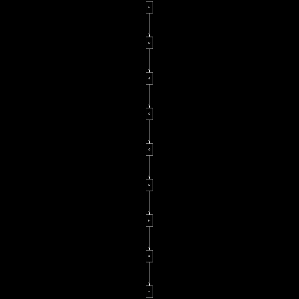

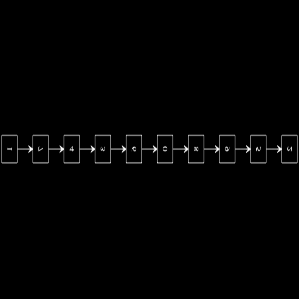

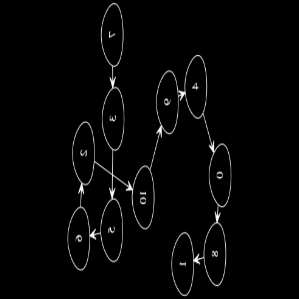

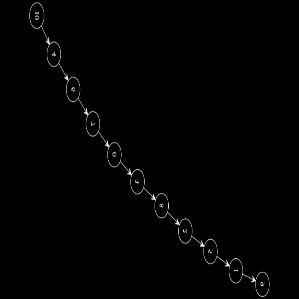

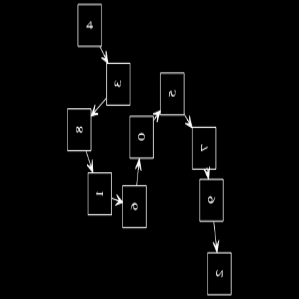

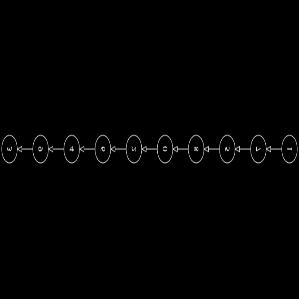

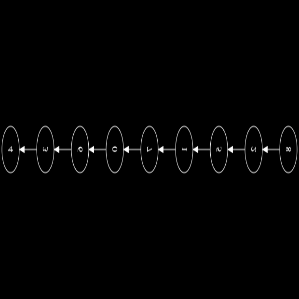

In [11]:
for i in range(10):
    showimg(data[0][i])

In [12]:
alphabet = list({e for s in data[1] for e in s})
alphabet.sort()
alphabet = "".join(alphabet)
print("ALPHABET: ", alphabet)
print("ALPHABET SIZE: ", len(alphabet))

ALPHABET:  0123456789;>{}
ALPHABET SIZE:  14


In [13]:
# alphabet = "abcdefghijklmnopqrstuvwxyz "
# absolute_max_string_len = 10

def get_output_size():
        return len(alphabet) + 1
    
blank_label = get_output_size() - 1

print("Alphabet size: ", get_output_size())
print("Max string length: ", absolute_max_string_len)

Alphabet size:  15
Max string length:  44


In [14]:
def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret

def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    print(ret)
    return "".join(ret)

In [15]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [16]:
IMG_WIDTH = 299
IMG_HEIGHT = 299
pool_size = 2
downsample_factor=(pool_size ** 2)

def create_model():
    img_w = IMG_WIDTH
    img_h = IMG_HEIGHT
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    time_dense_size = 32
    rnn_size = 512
    minibatch_size = 1  # 32

    input_shape = (img_w, img_h, 3)

    act = "relu"
    input_data = Input(name="the_input", shape=input_shape, dtype="float32")
    inner = Conv2D(
        conv_filters,
        kernel_size,
        padding="same",
        activation=act,
        kernel_initializer="he_normal",
        name="conv1",
    )(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name="max1")(inner)
    inner = Conv2D(
        conv_filters,
        kernel_size,
        padding="same",
        activation=act,
        kernel_initializer="he_normal",
        name="conv2",
    )(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name="max2")(inner)

    conv_to_rnn_dims = (
        img_w // (pool_size ** 2),
        (img_h // (pool_size ** 2)) * conv_filters,
    )
    inner = Reshape(target_shape=conv_to_rnn_dims, name="reshape")(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name="dense1")(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    # data shape input: (batch_size, timesteps, ...)
    # data output size: (batch_size, timesteps, output_size)
    gru_1 = GRU(
        rnn_size, return_sequences=True, kernel_initializer="he_normal", name="gru1"
    )(inner)
    gru_1b = GRU(
        rnn_size,
        return_sequences=True,
        go_backwards=True,
        kernel_initializer="he_normal",
        name="gru1_b",
    )(inner)
    gru1_merged = tf.keras.layers.add([gru_1, gru_1b])
    gru_2 = GRU(
        rnn_size, return_sequences=True, kernel_initializer="he_normal", name="gru2"
    )(gru1_merged)
    gru_2b = GRU(
        rnn_size,
        return_sequences=True,
        go_backwards=True,
        kernel_initializer="he_normal",
        name="gru2_b",
    )(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(
        get_output_size(), kernel_initializer="he_normal", name="dense2"
    )(tf.keras.layers.concatenate([gru_2, gru_2b]))
    y_pred = Activation("softmax", name="softmax")(inner)
    model = Model(inputs=input_data, outputs=y_pred)

    labels = Input(
        name="the_labels", shape=[absolute_max_string_len], dtype="float32"
    )
    input_length = Input(name="input_length", shape=[1], dtype="int64")
    label_length = Input(name="label_length", shape=[1], dtype="int64")
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [y_pred, labels, input_length, label_length]
    )

    # clipnorm seems to speeds up convergence
    # sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

    model_and_loss = Model(
        inputs=[input_data, labels, input_length, label_length], outputs=loss_out
    )
    
    
    sgd = RMSprop(lr=0.001, rho=0.9)
    
    model_and_loss.compile(
        loss={"ctc": lambda y_true, y_pred: y_pred},
        optimizer=sgd)

    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])
    
    return model, model_and_loss, test_func

In [17]:
model, model_and_loss, test_func = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 299, 299, 16) 448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 149, 149, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 149, 149, 16) 2320        max1[0][0]                       
______________________________________________________________________________________________

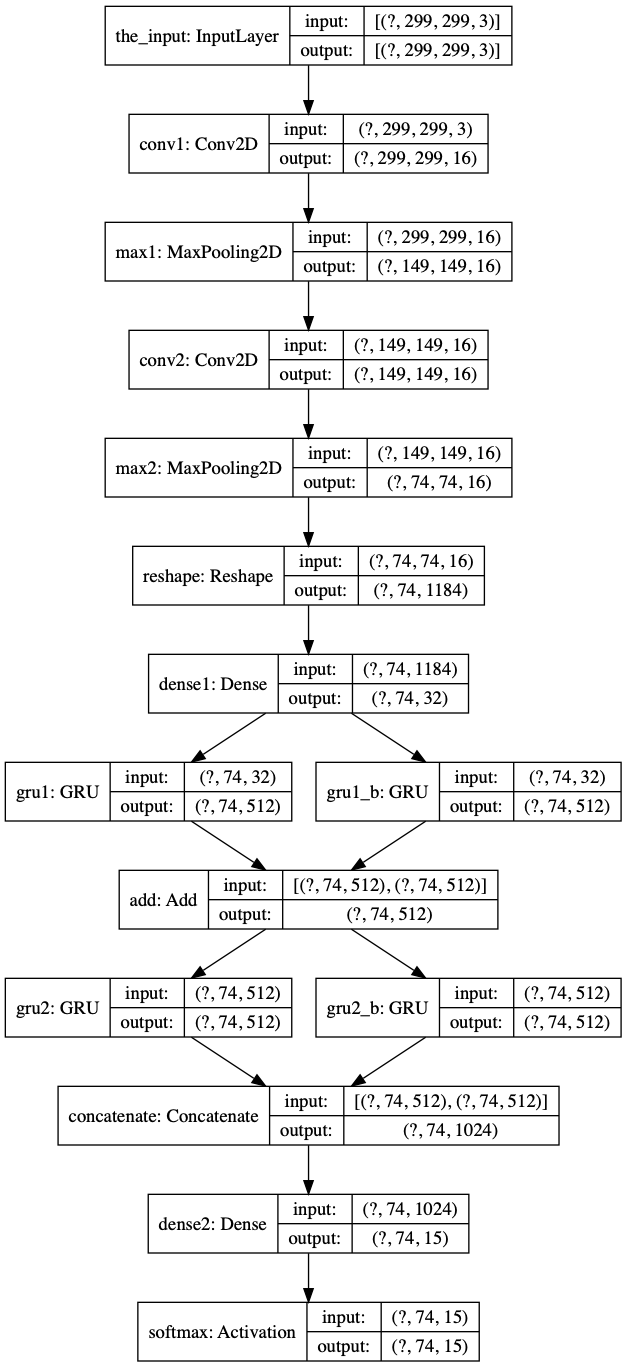

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

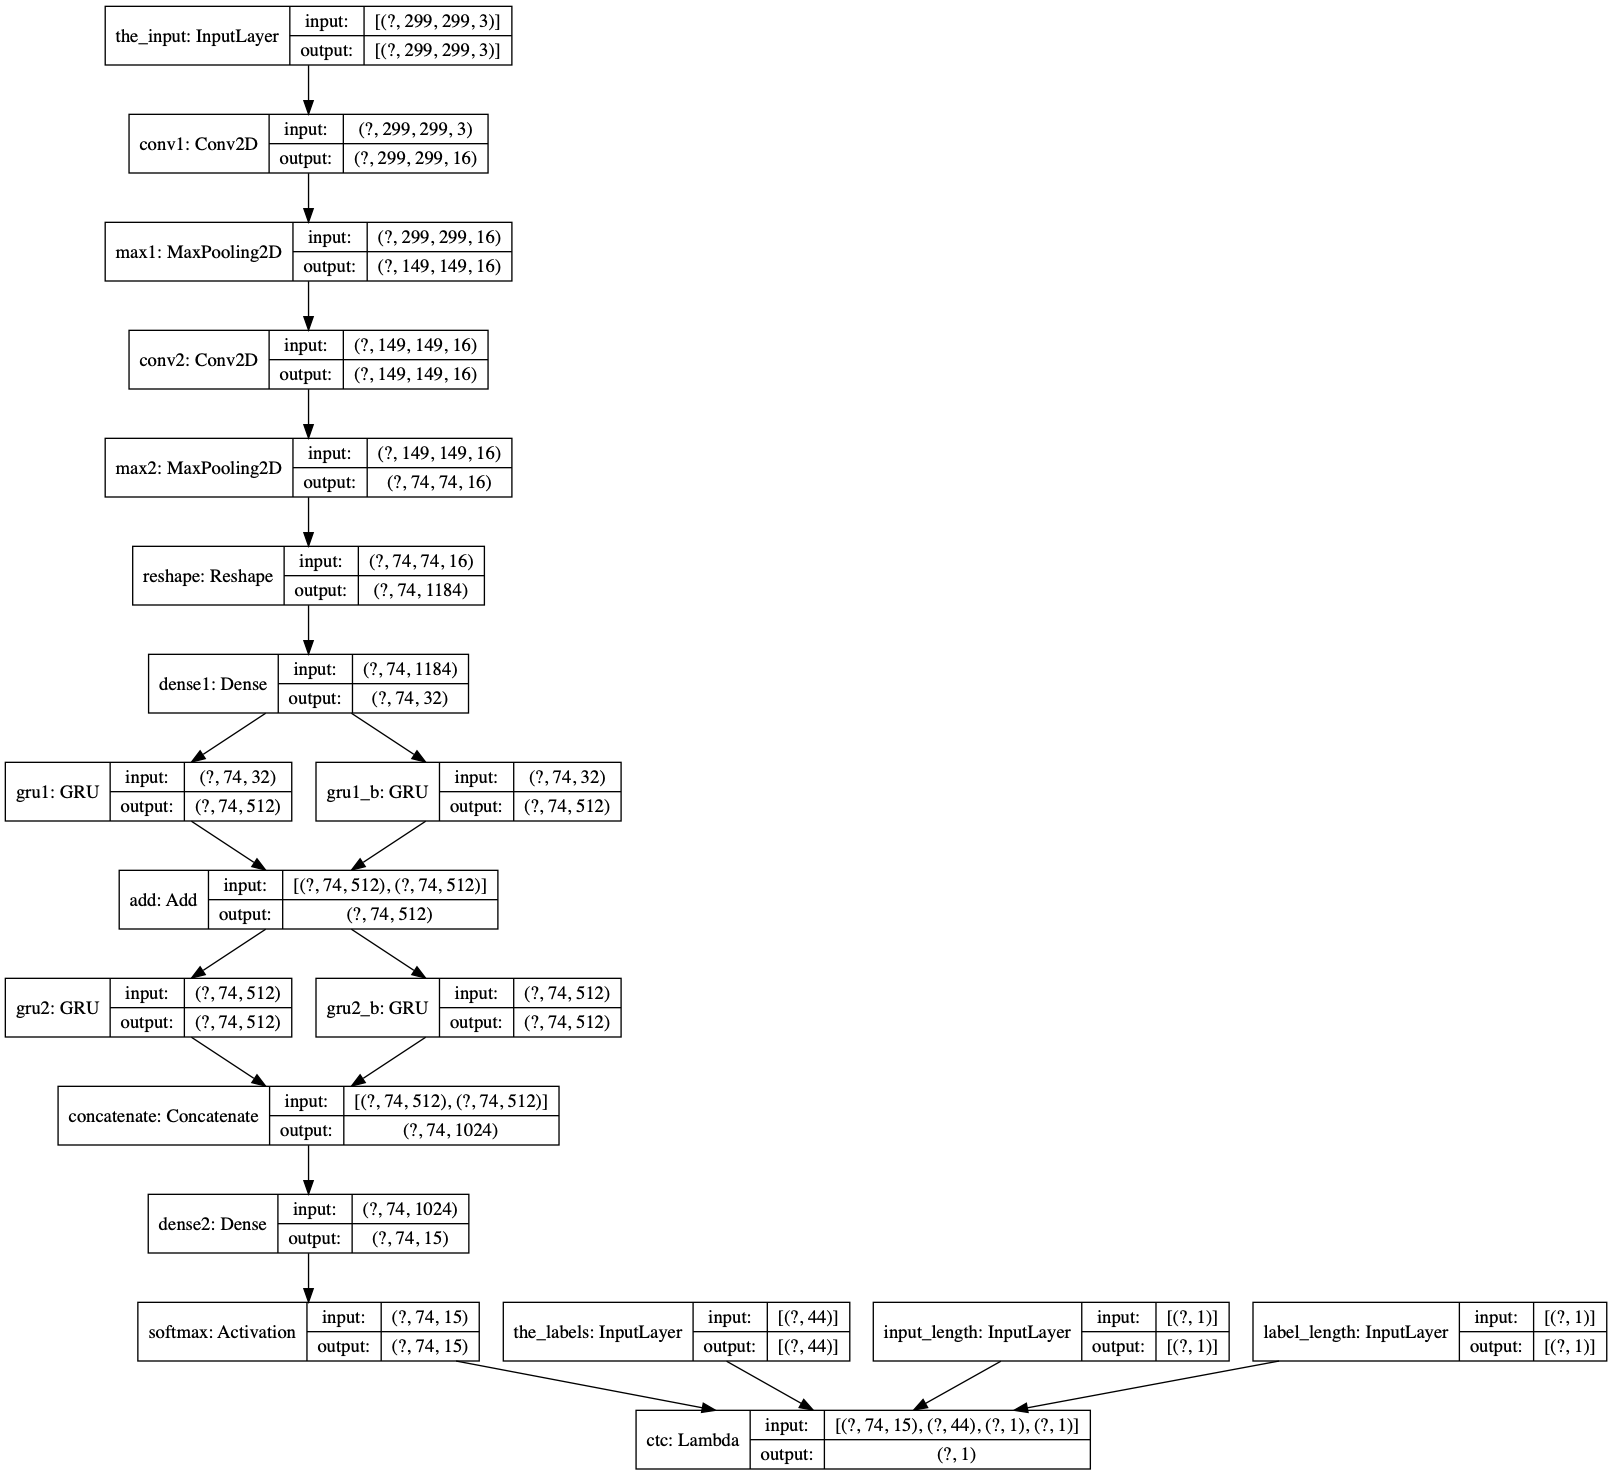

In [19]:
tf.keras.utils.plot_model(model_and_loss, show_shapes=True)

In [20]:
# res = model.predict([the_input_data, the_labels_data, input_length_data, label_length_data])
import itertools
def decode_batch(test_func, word_batch):
    """Decode a batch of input:
    
    Args:
        test_func (callable): test_func([word_batch])
        word_batch: input with shape (batch_size, img_width, img_hight, channels) such as (1, 100, 10, 1).
    Returns:
    """
    out = test_func([word_batch])# [0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

# decode_batch(model.predict, the_input_data)

In [21]:
def training_data():
    size = np.shape(data[0])[0]
    
    input_data = np.array(data[0])
    
    labels = np.ones([size, absolute_max_string_len]) * -1
    input_length = np.zeros([size, 1])
    labels_length = np.zeros([size, 1])
    for i, string in enumerate(data[1]):
        labels[i, 0:len(string)] = text_to_labels(string) 
        input_length[i] = IMG_WIDTH // downsample_factor - 2
        labels_length[i] = len(string)
    
    print("input_data shape: ", np.shape(input_data))
    print("labels shape: ", np.shape(labels))
    print("input_length shape: ", np.shape(input_length))
    print("labels_length shape: ", np.shape(labels_length))
    
    res = [
        input_data,
        labels,
        input_length,
        labels_length 
    ]
    return res

In [22]:
data = training_data()

input_data shape:  (2325, 299, 299, 3)
labels shape:  (2325, 44)
input_length shape:  (2325, 1)
labels_length shape:  (2325, 1)


In [23]:
def train(epochs):

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model_and_loss.fit(
        data,
        np.zeros([np.shape(data[0])[0]]),
#         steps_per_epoch=10,  # (words_per_epoch - val_words) // minibatch_size,
        batch_size=32,
        epochs=epochs,
    )


In [24]:
train(10)

Train on 2325 samples
Epoch 1/10
2325/2325 [==============================] - 147s 63ms/sample - loss: 75.4557
Epoch 2/10
2325/2325 [==============================] - 171s 73ms/sample - loss: 52.5184
Epoch 3/10
2325/2325 [==============================] - 144s 62ms/sample - loss: 42.4986
Epoch 4/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 36.2891
Epoch 5/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 32.3576
Epoch 6/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 35.2377
Epoch 7/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 35.0083
Epoch 8/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 30.4926
Epoch 9/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 30.2788
Epoch 10/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 33.2928


In [25]:
train(10)

Train on 2325 samples
Epoch 1/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 28.3619
Epoch 2/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 27.1234
Epoch 3/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 26.0104
Epoch 4/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 24.9807
Epoch 5/10
2325/2325 [==============================] - 141s 61ms/sample - loss: 24.1875
Epoch 6/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 23.2633
Epoch 7/10
2325/2325 [==============================] - 144s 62ms/sample - loss: 22.6798
Epoch 8/10
2325/2325 [==============================] - 143s 61ms/sample - loss: 21.9356
Epoch 9/10
2325/2325 [==============================] - 143s 62ms/sample - loss: 21.1637
Epoch 10/10
2325/2325 [==============================] - 142s 61ms/sample - loss: 20.1417


In [35]:
train(50)

Train on 2325 samples
Epoch 1/50
2325/2325 [==============================] - 143s 62ms/sample - loss: 11.2017
Epoch 2/50
2325/2325 [==============================] - 145s 62ms/sample - loss: 11.5697
Epoch 3/50
2325/2325 [==============================] - 143s 62ms/sample - loss: 11.6500
Epoch 4/50
2325/2325 [==============================] - 146s 63ms/sample - loss: 11.2456
Epoch 5/50
2325/2325 [==============================] - 150s 65ms/sample - loss: 10.7529
Epoch 6/50
2325/2325 [==============================] - 150s 65ms/sample - loss: 10.3911
Epoch 7/50
2325/2325 [==============================] - 154s 66ms/sample - loss: 10.1642
Epoch 8/50
2325/2325 [==============================] - 150s 64ms/sample - loss: 9.6925
Epoch 9/50
2325/2325 [==============================] - 150s 65ms/sample - loss: 9.4314
Epoch 10/50
2325/2325 [==============================] - 147s 63ms/sample - loss: 9.0768
Epoch 11/50
2325/2325 [==============================] - 150s 65ms/sample - loss: 8.4825
E

In [25]:
pred = model.predict(data[0][:1])

In [26]:
np.shape(pred)

(1, 74, 15)

In [27]:
i = 20
decode_batch(model.predict, data[0][i:i+1])

['{', '5', '>', '6', ';', '6', '>', '5', ';', '5', '>', '0', ';', '0', '>', '2', ';', '2', '>', '1', ';', '1', '>', '0', ';', '}']


['{5>6;6>5;5>0;0>2;2>1;1>0;}']

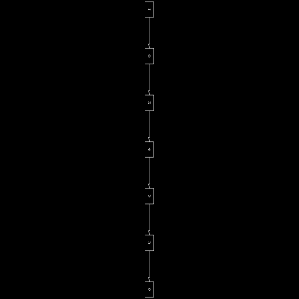

In [28]:
showimg(data[0][i])

In [40]:
model_and_loss.save_weights("weights.h5")

In [24]:
model_and_loss.load_weights("weights-perms.h5")

In [78]:
def convert_from_jpg(path_img_file):
    img = tf.io.read_file(path_img_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.transpose(img)
    img = tf.constant(255, dtype=tf.uint8) - img
    img = tf.image.resize_with_pad(img, target_height=max_height, target_width=max_width)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img

In [82]:
img_test = convert_from_jpg("test/graph6.png")

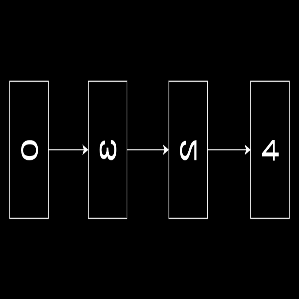

In [83]:
showimg(img_test)

In [84]:
decode_batch(model.predict, [img_test])

['{', '0', '>', '1', ';', '1', '>', ';', '>', '3', ';', '}']


['{0>1;1>;>3;}']

In [35]:
import neural_structured_learning as nsl

adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model_and_loss, adv_config=adv_config)

# Compile, train, and evaluate.
# adv_model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy'])

sgd = RMSprop(lr=0.001, rho=0.9)

adv_model.compile(
    loss={"ctc": lambda y_true, y_pred: y_pred},
    optimizer=sgd)

#         input_data,
#         labels,
#         input_length,
#         labels_length 

for i, d in enumerate(data):
    print(i, np.shape(d))

hist = adv_model.fit(
#     {'feature': X_train, 'label': y_train},
    {
        'the_inputs': data[0],
        'the_labels': data[1],
        'input_length': data[2],
        'label_length': data[3],
#         'label': np.zeros([np.shape(data[0])[0]])
        'label': np.zeros([np.shape(data[0])[0], 74, 15])
    },
#     data,
    batch_size=32, epochs=1)

0 (2325, 299, 299, 3)
1 (2325, 44)
2 (2325, 1)
3 (2325, 1)


ValueError: in converted code:
    relative to /Users/romainegele/opt/anaconda3/envs/dh/lib/python3.7/site-packages:

    neural_structured_learning/keras/adversarial_regularization.py:627 call  *
        outputs, labeled_loss, metrics, tape = self._forward_pass(
    neural_structured_learning/keras/adversarial_regularization.py:606 _forward_pass  *
        outputs = self.base_model(inputs, **base_model_kwargs)
    tensorflow_core/python/keras/engine/base_layer.py:842 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    tensorflow_core/python/keras/engine/input_spec.py:177 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv1 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 1]
